# **Imports and setup**

The notebook can be run in Google Colab, because the local machine had no GPU. Requirements can be found in requirements.txt

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim

from utils import *
from train import train_quantgan

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Get the data for SP500 from May 2009 till Dec 2018 (as in the original paper)
sp500 = yf.download('^GSPC','2009-05-01','2018-12-31')

[*********************100%***********************]  1 of 1 completed


## **Preprocessing**

In [3]:
sp500log = np.log(sp500['Close'] / sp500['Close'].shift(1))[1:].values

We see thick tails of distribution:

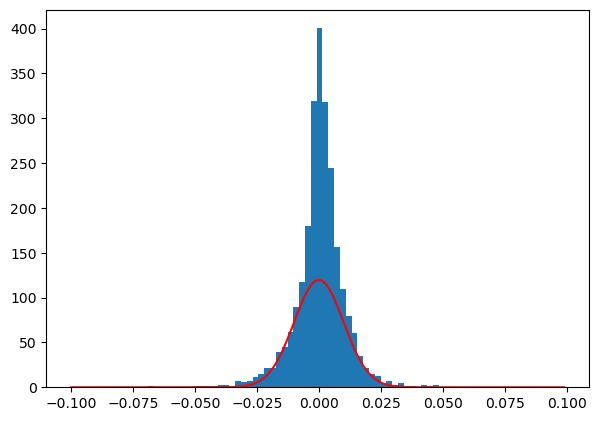

In [4]:
plt.hist(sp500log, bins=50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 3, color= 'r')
plt.show()

Perform an inverse Lambert transformation and re-normalization using IGMM algorithm.


In [5]:
sp500log_mean = np.mean(sp500log)
sp500log_norm = sp500log - sp500log_mean
params = igmm(sp500log_norm)
sp500processed = W_delta((sp500log_norm - params[0]) / params[1], params[2])
sp500max = np.max(np.abs(sp500processed))
sp500processed /= sp500max

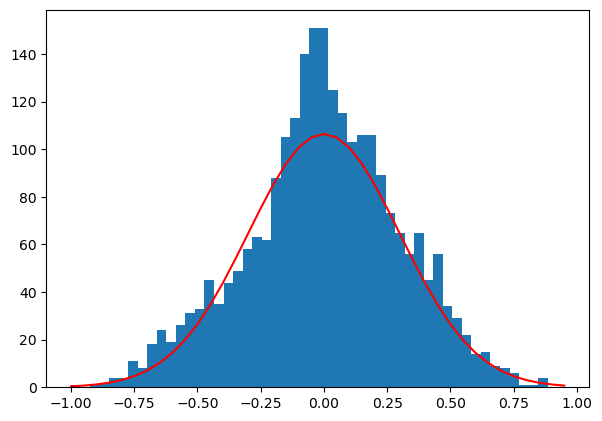

In [6]:
plt.hist(sp500processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 80, color= 'r')
plt.show()

# **Prepare and train GAN**

In [7]:
# train_quantgan(sp500processed = sp500processed, 
#                clip_value = 0.01, lr = 0.0002,
#               num_epochs = 50, nz = 3,
#               batch_size = 30, seq_len = 127)

Loss_D: -0.00003558 Loss_G: -0.49672890: 100%|██████████| 50/50 [9:59:17<00:00, 719.16s/it]    


Load our model

In [15]:
netG = torch.load('sp500_netG_epoch_49.pth')

#**Probe generation**

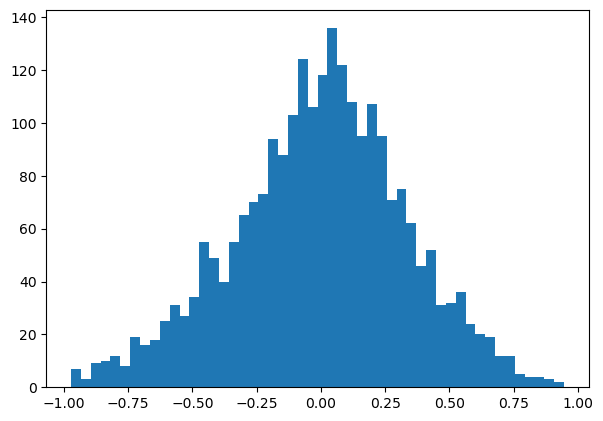

In [16]:
noise = torch.randn(1, 2432, 3, device=device)
fake = netG(noise).detach().cpu().reshape(2432).numpy()
plt.hist(fake, bins=50)
plt.show()

Now we revert preprocessing steps to get a simulated trajectory.

In [17]:
sp500fake = inverse(fake * sp500max, params) 

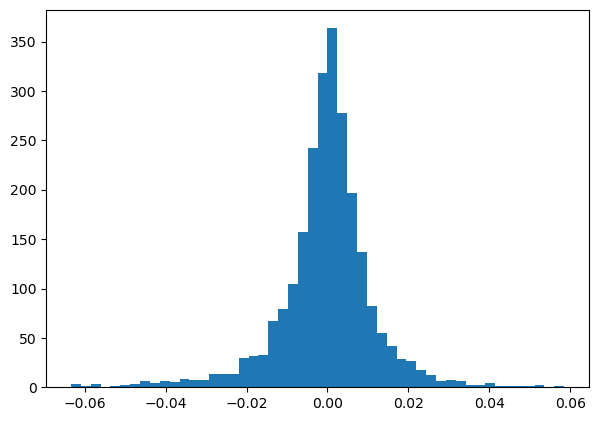

In [18]:
plt.hist(sp500fake, bins=50)
plt.show()

## Visualize results

In [19]:
def generate_fakes(n=1, cumsum=True):
  fakes = []
  for i in range(n):
    noise = torch.randn(1, 2432, 3, device=device)
    fake = netG(noise).detach().cpu().reshape(2432).numpy()
    sp500fake = inverse(fake * sp500max, params) + sp500log_mean
    fakes.append(sp500fake)
  if n > 1:
    if not cumsum:
      return pd.DataFrame(fakes).T
    fakes_df = pd.DataFrame(fakes).T.cumsum()
    return fakes_df
  elif not cumsum:
    return sp500fake
  return sp500fake.cumsum()

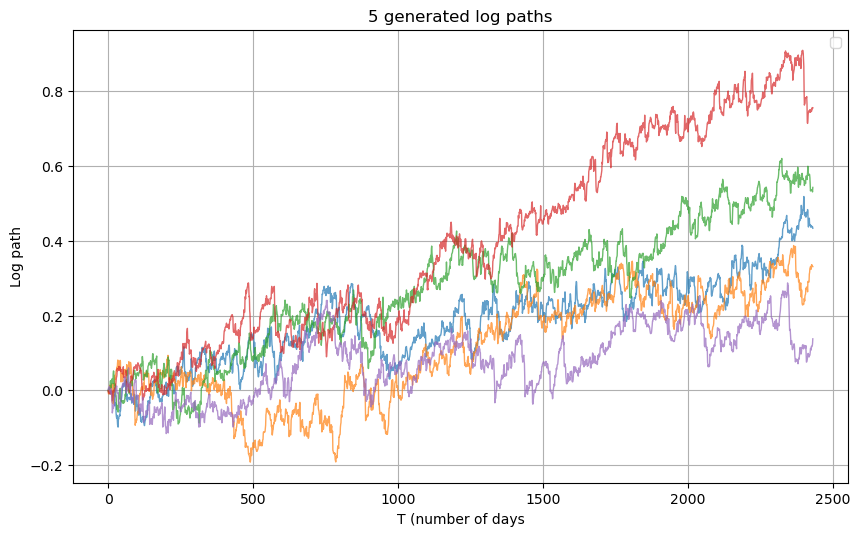

In [20]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(5), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('5 generated log paths');

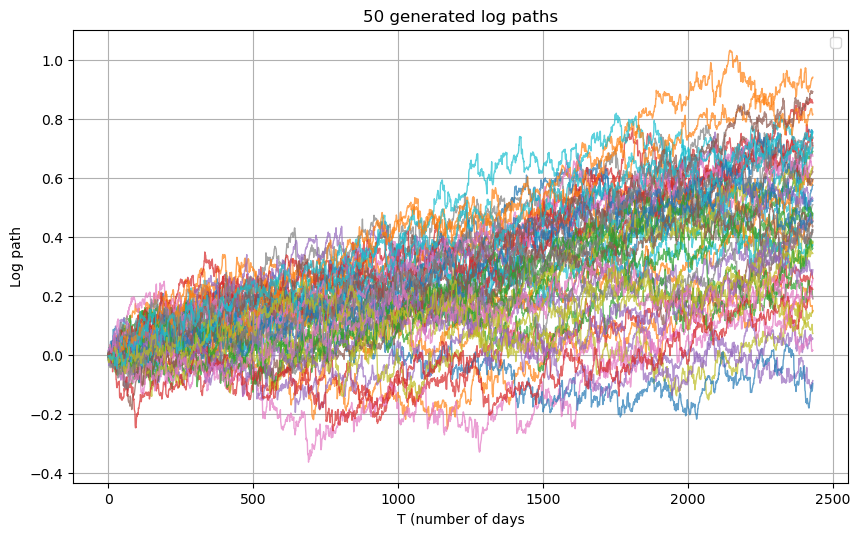

In [21]:
plt.figure(figsize=(10,6))
plt.plot(generate_fakes(50), linewidth=1, alpha=0.7)
plt.legend('')
plt.grid(True)
plt.xlabel('T (number of days')
plt.ylabel('Log path')
plt.title('50 generated log paths');

In [28]:
len(sp500)

2434

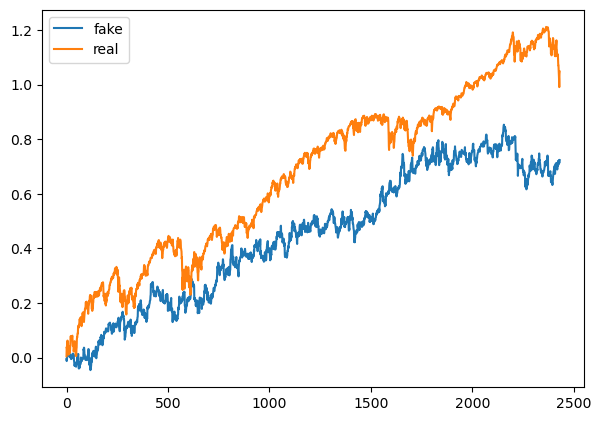

In [42]:
comp_df = pd.DataFrame({'fake': generate_fakes(), 'real': sp500log.cumsum()[:2432]})
comp_df.plot()

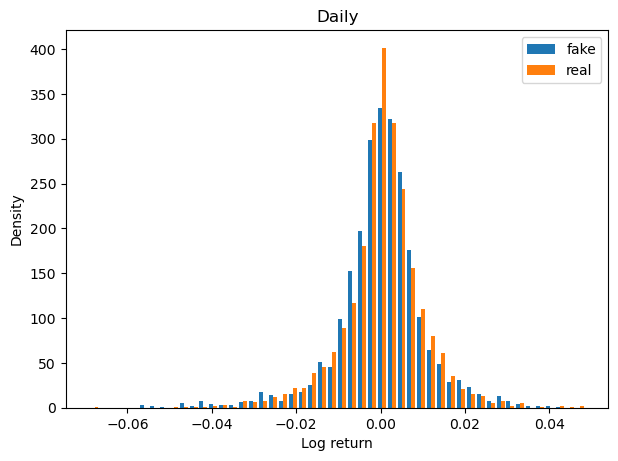

In [43]:
plt.hist([comp_df['fake'].diff(), comp_df['real'].diff()], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Daily')
plt.show()

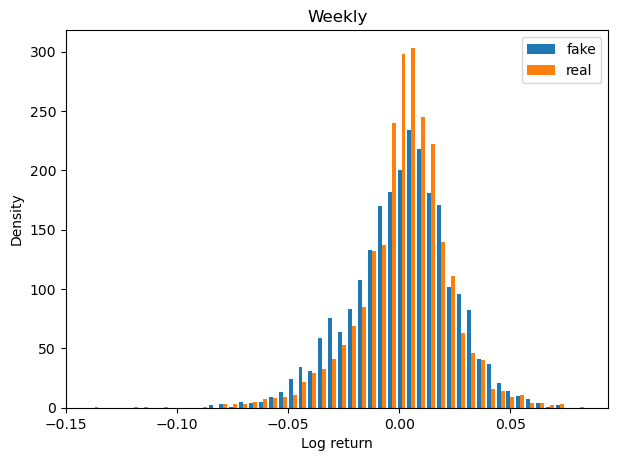

In [44]:
plt.hist([comp_df['fake'].diff(5), comp_df['real'].diff(5)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Weekly')
plt.show()

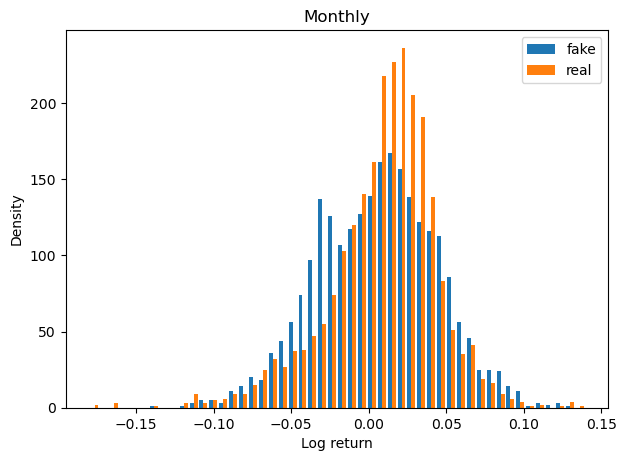

In [45]:
plt.hist([comp_df['fake'].diff(20), comp_df['real'].diff(20)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('Monthly')
plt.show()

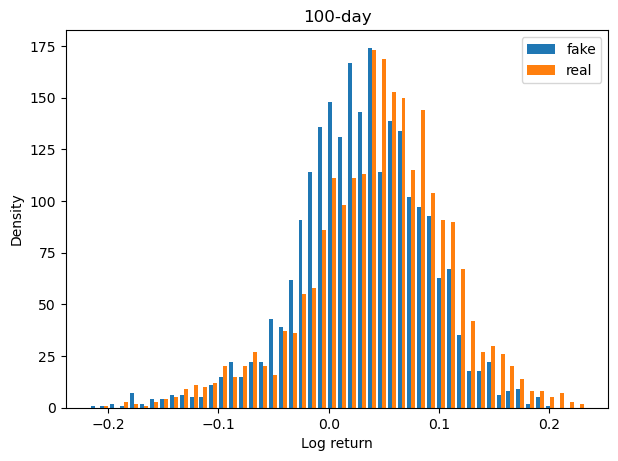

In [46]:
plt.hist([comp_df['fake'].diff(100), comp_df['real'].diff(100)], bins=50, label=['fake', 'real'])
plt.legend(loc='upper right')
plt.xlabel('Log return')
plt.ylabel('Density')
plt.title('100-day')
plt.show()

In [47]:
def autocorr(x, n=50):
  if len(x.shape) > 1:
    x = x.mean(axis=1)
  result = np.correlate(x, x, mode='full')
  return pd.DataFrame(result[result.size//2:][:n])

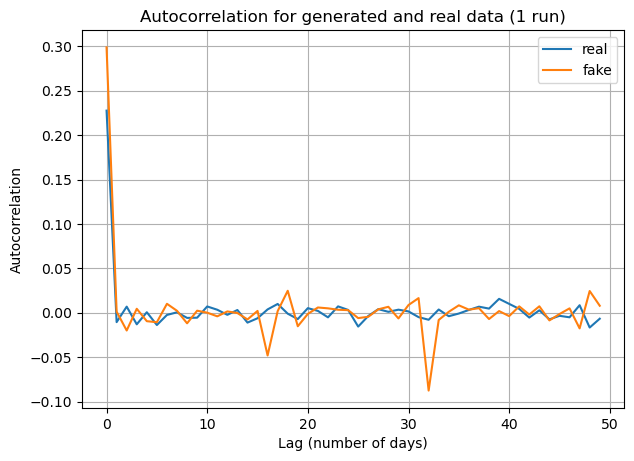

In [48]:
fakes = generate_fakes(cumsum=False)
correlations_normal_real = autocorr(sp500log)
correlations_normal_fake = autocorr(fakes)

plt.plot(correlations_normal_real, label='real')
plt.plot(correlations_normal_fake, label='fake')
plt.grid(True)
plt.legend()
plt.title('Autocorrelation for generated and real data (1 run)')
plt.xlabel('Lag (number of days)')
plt.ylabel('Autocorrelation')
plt.show()

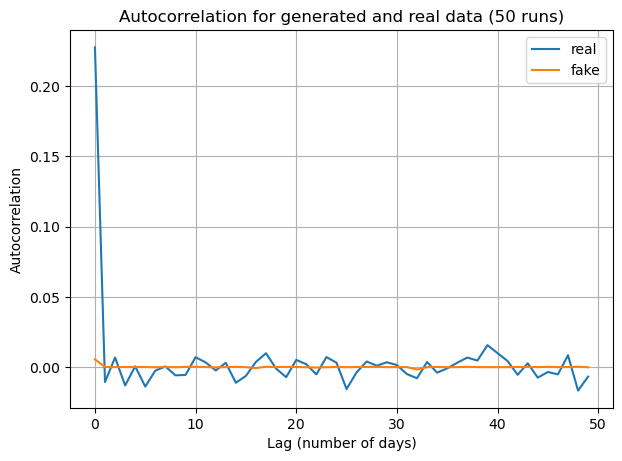

In [49]:
fakes = generate_fakes(50, cumsum=False)
correlations_normal_real = autocorr(sp500log)
correlations_normal_fake = autocorr(fakes)

plt.plot(correlations_normal_real, label='real')
plt.plot(correlations_normal_fake, label='fake')
plt.grid(True)
plt.legend()
plt.title('Autocorrelation for generated and real data (50 runs)')
plt.xlabel('Lag (number of days)')
plt.ylabel('Autocorrelation')
plt.show()